In [18]:
#import all the needed libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from IPython.display import display
import seaborn as sns
import random
from sklearn.metrics import accuracy_score

%matplotlib inline

In [19]:
#read the data
data = pd.read_csv('Wine.csv')
data = data.drop("Index", axis=1)
data['Target'].astype(str).astype(int)
data['Type'].astype(str)

data.replace('white_wine', 1, inplace = True)
data.replace('red_wine', 0, inplace = True)

print(data.isna().sum())

#let's delete all the rows containing NaN values
#there are only 49 of them, assuming that total quantity is 
#approximately 5600, so we can do that

data = data.dropna(0).reset_index(drop=True)
data = data.drop_duplicates().reset_index(drop=True)

Target       0
Type         0
Alcohol      0
Density      0
Nitrogen     0
pH           0
Sugar        0
A           33
B            0
C            0
D            0
Di           0
E            0
H           16
S            0
U            0
V            0
dtype: int64


In [3]:
#this way we'll find some statistics and will be able 
#to identify some outliers
display(np.round(data.describe().T))

,count,mean,std,min,25%,50%,75%,max
Target,5551.0,4.0,1.0,1.0,3.0,4.0,4.0,6.0
Type,5551.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
Alcohol,5551.0,8.0,1.0,7.0,8.0,8.0,9.0,11.0
Density,5551.0,1.0,0.0,1.0,1.0,1.0,1.0,10.0
Nitrogen,5551.0,5.0,4.0,0.0,3.0,4.0,7.0,31.0
pH,5551.0,3.0,0.0,3.0,3.0,3.0,4.0,4.0
Sugar,5551.0,6.0,5.0,1.0,2.0,3.0,8.0,63.0
A,5551.0,25.0,3.0,18.0,23.0,24.0,26.0,42.0
B,5551.0,3.0,2.0,0.0,2.0,3.0,4.0,16.0
C,5551.0,5.0,2.0,0.0,4.0,5.0,6.0,25.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c01fb50>,
      dtype=object)

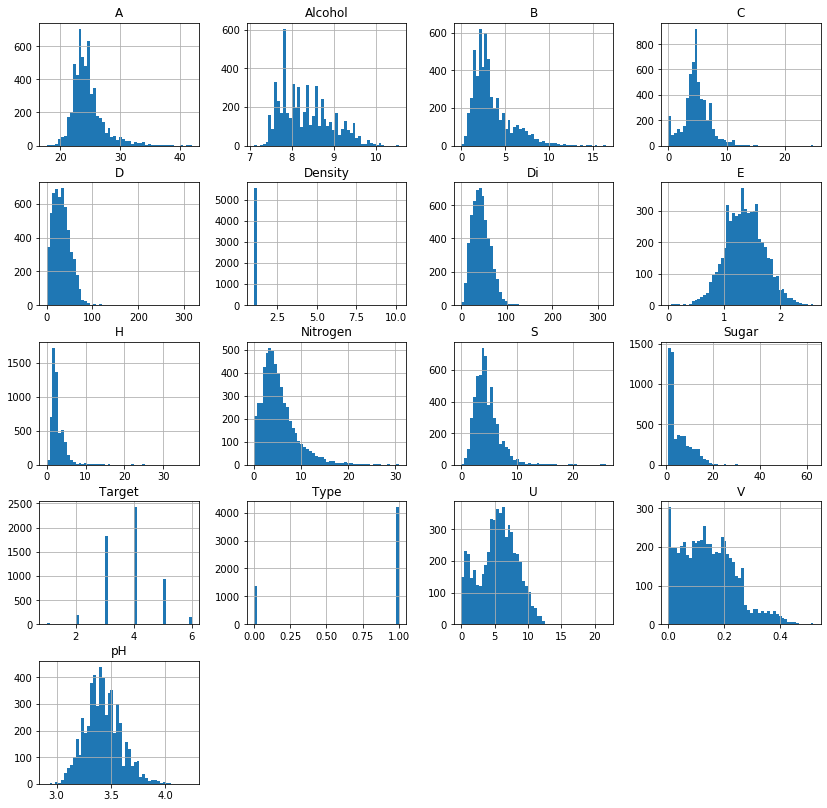

In [4]:
#now we'll draw some histograms
display(data.hist(bins=50, figsize=(14, 14)))

Type        6.374048
Alcohol     3.255278
Density     1.168181
Nitrogen    2.099553
pH          3.510356
Sugar       4.317061
A           4.380678
B           5.092610
C           3.118969
D           5.335399
Di          5.281304
E           1.590371
H           4.247255
S           3.834977
U           6.055757
V           3.150158
dtype: float64


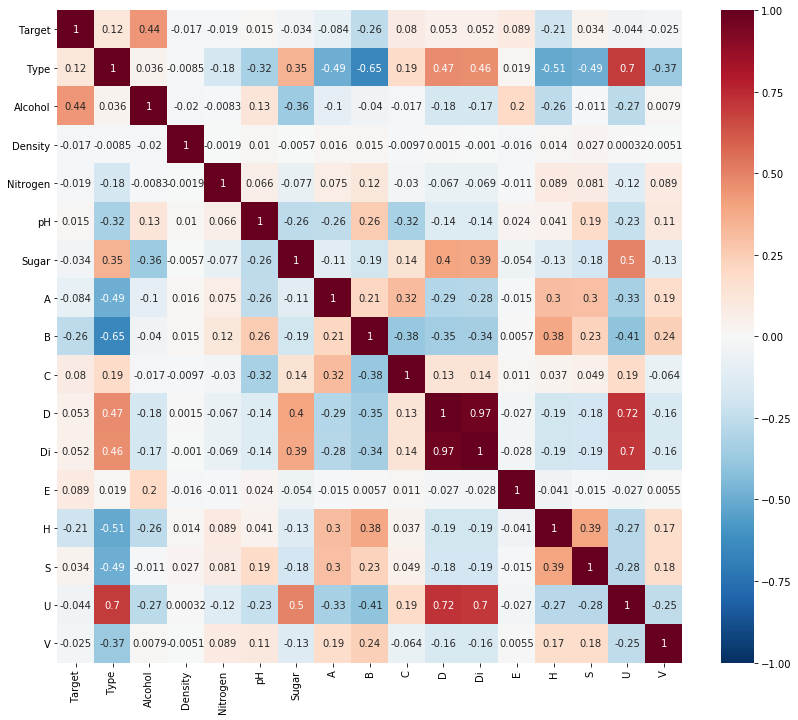

In [5]:
#let's check some correlation and find out the most necessary and unnecessary ones.
correlation = data.corr()
plt.figure(figsize = (14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin = -1, cmap = "RdBu_r")
print(correlation[correlation.columns].abs().sum()[1:])

In [20]:
#first of all I'm going to drop Density column as the correlation
#value is quite low and it will simplify our model. Almost the same situation with "E" column. 
data = data.drop("Density", axis=1)
data = data.drop("E", axis=1)
#Then we can see that 75%-meaning of "Nitrogen", 
#"Sugar", "D", "Di" is much
#less than their max values as well as several other columns.
#Consequently we'll have to normalize data in this columns as there
#are some outliers.

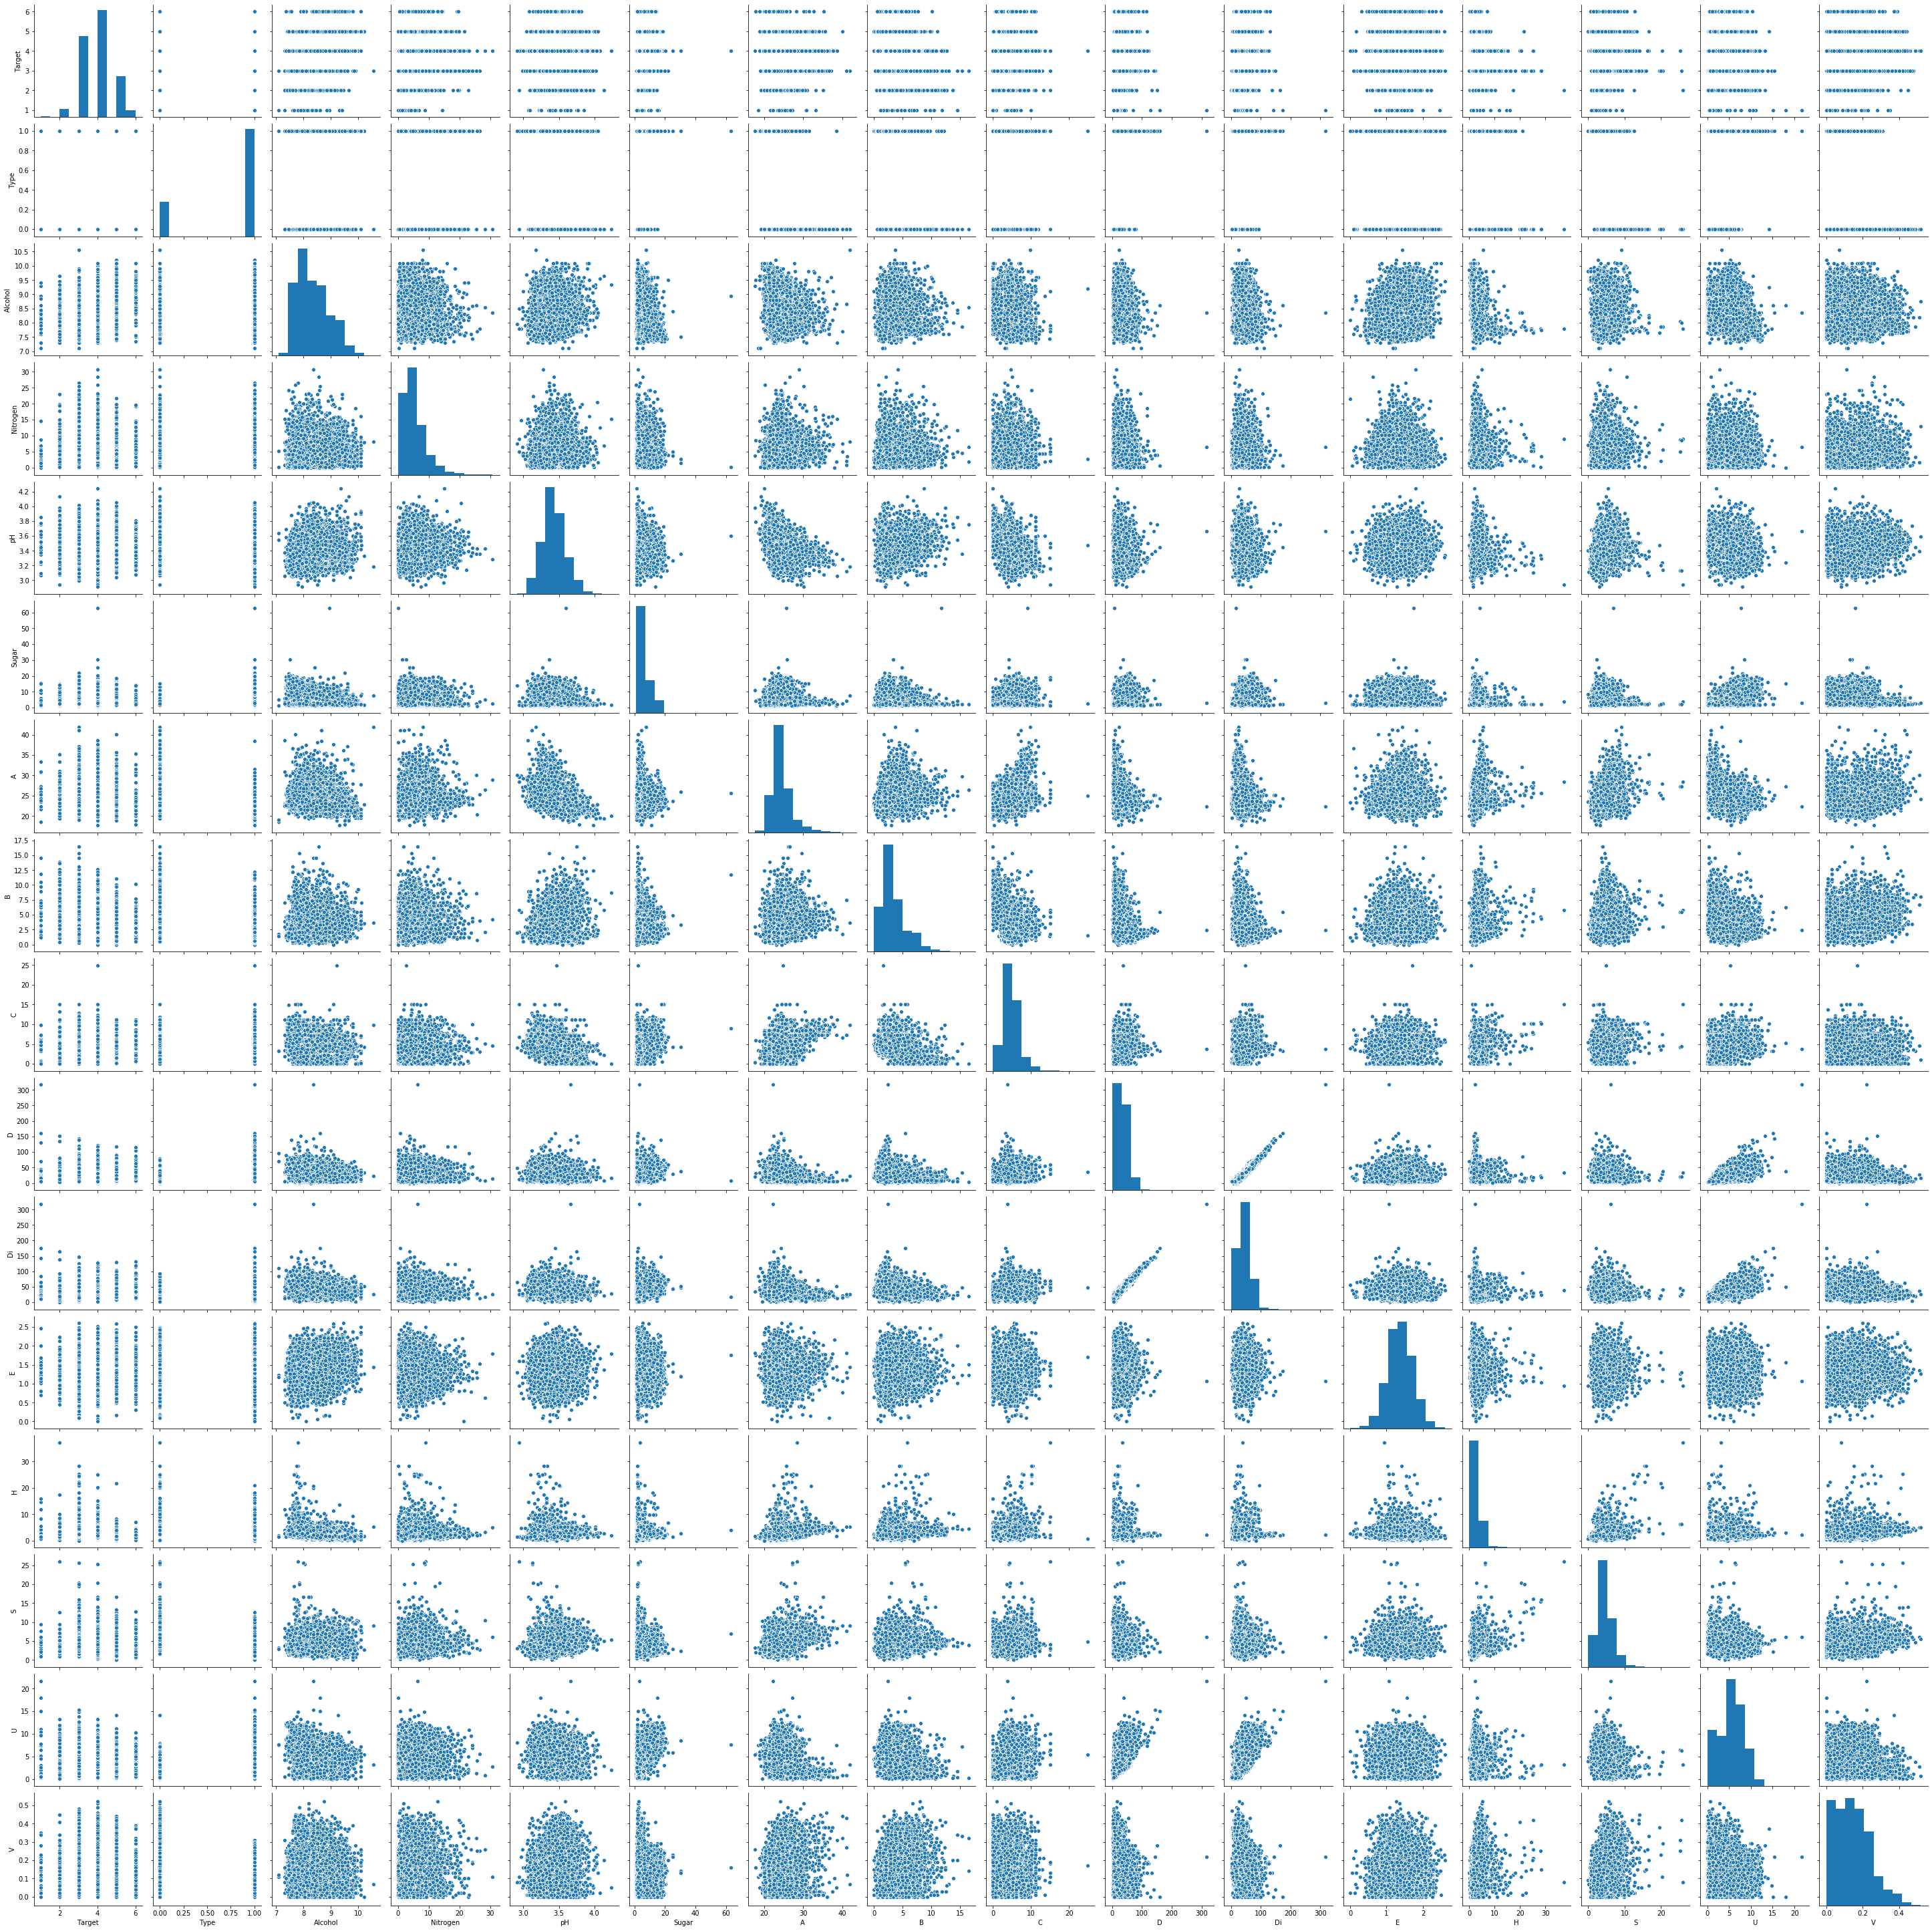

In [343]:
display(sns.pairplot(data))

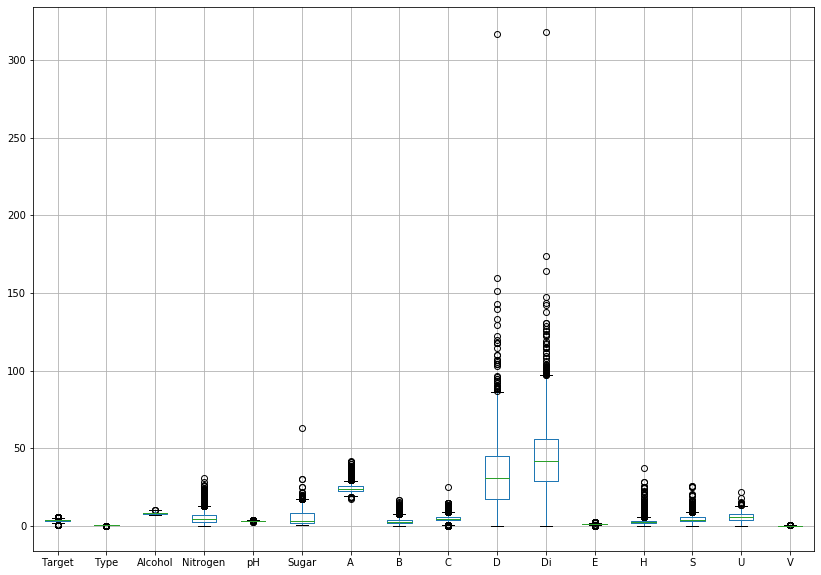

In [344]:
display(data.boxplot(figsize=(14, 10)))

In [345]:
#data_to_delete = data[data['Di']>=data['Di'].quantile(0.99)]
#print(data_to_delete.index)
#data = data.drop(data_to_delete.index, axis=0).reset_index(drop=True)
#display(data.boxplot(figsize=(14, 10)))

In [21]:
#now we'll split dataset into train and test batches, separately for every model.
#dataset from the "Test.csv" will be the validation one.

train_batch = data.to_numpy(dtype='float64')[:, 1:]
train_labels = data.iloc[:,:1].to_numpy()
train_labels = train_labels-1

from sklearn.model_selection import train_test_split

#we'll split out target values into three classes: (5,6)->"good ones", (3,4)->"normal ones", (1,2)->"bad ones"
#it'll simplify the model and won't change the sens.

def labelList(x):
    temporary = [0, 0, 0]
    if (x<=1):
        temporary[0] = 1
    elif x>=4:
        temporary[2] = 1
    else:
        temporary[1] = 1
    return temporary

def labelListforSVM(x):
    if (x<=1):
        return 0
    elif x>=4:
        return 2
    else:
        return 1

train_batch_for_svm, train_labels_for_svm = train_batch, train_labels

train_batch_for_svm, test_batch_for_svm, train_labels_for_svm, test_labels_for_svm = train_test_split(
    train_batch_for_svm[:, :], 
    train_labels_for_svm, 
    test_size=0.2, 
    shuffle=True)

for _ in train_labels_for_svm:
    _[0] = labelListforSVM(_[0])

for _ in test_labels_for_svm:
    _[0] = labelListforSVM(_[0])


train_labels = np.array([labelList(x[0]) for x in train_labels])

train_batch, test_batch, train_labels, test_labels = train_test_split(
    train_batch[:, :], 
    train_labels, 
    test_size=0.2, 
    shuffle=True)

In [22]:
np.random.seed(0)
random.seed(0)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #self.dropout = torch.nn.Dropout(p=0.2)

        self.fc1 = torch.nn.Linear(14, 25)
        self.conv1_bn = torch.nn.BatchNorm1d(25)
        self.activ1 = torch.nn.Sigmoid()

        self.fc2 = torch.nn.Linear(25, 12)
        self.conv1_bn = torch.nn.BatchNorm1d(12)
        self.activ2 = torch.nn.Sigmoid()
        
        self.fc3 = torch.nn.Linear(12, 3)
        self.activ3 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
net = Net()

In [23]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(net.parameters(), 
                             lr=1.0e-3)
    
train_batch = torch.FloatTensor(train_batch)
train_labels = torch.LongTensor(train_labels)

test_batch = torch.FloatTensor(train_batch)
test_labels = torch.LongTensor(train_labels)

In [ ]:
minibatch_size = 50

accuracy_history = []

for epoch in range(5000):
    order = np.random.permutation(len(train_batch))
    for start_index in range(0, len(train_batch), minibatch_size):
        optimizer.zero_grad() 
        minibatch_indexes = order[start_index:start_index+minibatch_size]
        train_minibatch = train_batch[minibatch_indexes]
        train_minitarget = train_labels[minibatch_indexes]
        preds = net(train_minibatch)
        loss_value = loss(preds, torch.max(train_minitarget, 1)[1])
        loss_value.backward()
        optimizer.step()
    if epoch % 100 == 0:
        with torch.no_grad():
            net.eval()   
            test_preds = net.forward(test_batch)
            print(loss(test_preds, torch.max(test_labels, 1)[1]).item())  
            accuracy = (test_preds.argmax(dim=1) == torch.max(test_labels, 1)[1]).float().mean().data.cpu()
            print(accuracy)
            accuracy_history.append(accuracy)
        net.train()
        
        
plt.plot(accuracy_history)



0.30217623710632324
tensor(0.8745)
0.30105918645858765
tensor(0.8732)
0.29823973774909973
tensor(0.8741)
0.2969874441623688
tensor(0.8739)
0.2967761754989624
tensor(0.8725)
0.2942836582660675
tensor(0.8757)
0.2924576699733734
tensor(0.8788)
0.29163506627082825
tensor(0.8806)
0.29571419954299927
tensor(0.8750)
0.2929414212703705
tensor(0.8782)
0.28803566098213196
tensor(0.8779)


In [16]:
from sklearn.svm import SVC

train_labels_for_svm = train_labels_for_svm.reshape(len(train_labels_for_svm),)

test_labels_for_svm = test_labels_for_svm.reshape(len(test_labels_for_svm),)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_batch_for_svm = sc.fit_transform(train_batch_for_svm)
test_batch_for_svm = sc.transform(test_batch_for_svm)

classifier = SVC(kernel = 'rbf', random_state = 0)
trained_model = classifier.fit(train_batch_for_svm, train_labels_for_svm)
trained_model.fit(train_batch_for_svm, train_labels_for_svm)

svm_preds = classifier.predict(test_batch_for_svm)

print("Accuracy score of train SVM")
print(accuracy_score(train_labels_for_svm, trained_model.predict(train_batch_for_svm)))

print("Accuracy score of test SVM")
print(accuracy_score(test_labels_for_svm, trained_model.predict(test_batch_for_svm)))

Accuracy score of train SVM
0.8072072072072072
Accuracy score of test SVM
0.8001800180018002
